In [62]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import wave

In [63]:
def audio2frame(signal, frame_size, frame_stride):
    '''将音频信号转化为帧。
	参数含义：
	signal:原始音频型号
	frame_length:每一帧的长度(这里指采样点的长度，即采样频率乘以时间间隔)
	frame_step:相邻帧的间隔（同上定义）
    '''
    signal_length = len(signal)  # 信号总长度
    frame_length = int(round(frame_size * sample_rate))  # 一帧帧时间长度
    frame_step = int(round(frame_stride * sample_rate))  # 相邻帧之间的步长
    frames_num = int(numpy.ceil((1.0 * signal_length - frame_length) / frame_step)) + 2
    pad_signal_length = (frames_num - 1) * frame_step + frame_length  # 所有帧加起来总的铺平后的长度
    z = numpy.zeros((pad_signal_length - signal_length))
    pad_signal = numpy.append(signal, z)
    indices = numpy.tile(numpy.arange(0, frame_length), (frames_num, 1)) + numpy.tile(
        numpy.arange(0, frames_num * frame_step, frame_step),
        (frame_length, 1)).T  # 相当于对所有帧的时间点进行抽取，得到frames_num*frame_length长度的矩阵
    frames = pad_signal[numpy.mat(indices).astype(numpy.int32, copy=False)]  # 将indices转化为矩阵
    frames = pad_signal[indices]  # 得到帧信号
    return frames, frame_length, indices  # 返回帧信号矩阵

In [64]:
wav_path = "airport-barcelona-0-0-a.wav"
with wave.open(wav_path, 'r') as wav_file:
    num_channels = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()
    num_frames = wav_file.getnframes()
    raw_frames = wav_file.readframes(-1)

In [65]:
print(sample_rate,num_channels,sample_width,num_frames)

48000 2 3 480000


In [66]:
temp_buffer = np.empty((num_frames, num_channels, 4), dtype=np.uint8)
raw_bytes = np.frombuffer(raw_frames, dtype=np.uint8)
temp_buffer[:, :, :sample_width] = raw_bytes.reshape(-1, num_channels, 
                                                    sample_width)
temp_buffer[:, :, sample_width:] = \
    (temp_buffer[:, :, sample_width-1:sample_width] >> 7) * 255
frames = temp_buffer.view('<i4').reshape(temp_buffer.shape[:-1])

In [67]:
print(frames.ndim)
signal=frames

2


In [68]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

In [69]:
# 分帧
frame_size = 0.04
frame_stride = 0.02

In [70]:
frames, frame_length, indices = audio2frame(signal, frame_size, frame_stride)

In [71]:
# 加汉明窗
frames *= numpy.hamming(frame_length)

# 傅立叶变换和功率谱
NFFT = 2048
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

low_freq_mel = 0
# 将频率转换为Mel
nfilt = 40
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # 将Hz转换为Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # 使得Mel scale间距相等
hz_points = (700 * (10 ** (mel_points / 2595) - 1))  # 将Mel转换为Hz

bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))

for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])  # left
    f_m = int(bin[m])  # center
    f_m_plus = int(bin[m + 1])  # right
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # 数值稳定性
filter_banks = 20 * numpy.log10(filter_banks)  # dB
filter_banks = filter_banks.T

In [72]:
print(frames)

[[ -2.48000000e+00  -2.54727851e+02   7.80896260e+01 ...,   3.48282932e+02
   -1.83205646e+02   4.79120000e+02]
 [  1.47216000e+03   4.52733953e+02   1.28951896e+03 ...,  -8.15060471e+02
    5.96018369e+02  -8.47440000e+02]
 [ -2.54800000e+02   5.65377425e+02  -2.41549776e+02 ...,   1.83510621e+03
    2.23478888e+03   1.68800000e+03]
 ..., 
 [  8.02720000e+02   9.04827887e+02   8.64826606e+02 ...,   1.85870912e+03
    2.40967427e+02   1.95752000e+03]
 [  4.44720000e+02   8.57146417e+02   3.31080812e+02 ...,  -2.56655638e+03
   -1.13363494e+03  -2.54976000e+03]
 [  5.90000000e+02   1.84669692e+03   7.39691181e+02 ...,   1.24375332e+03
    5.20016027e+01   1.21296000e+03]]


(40, 500)


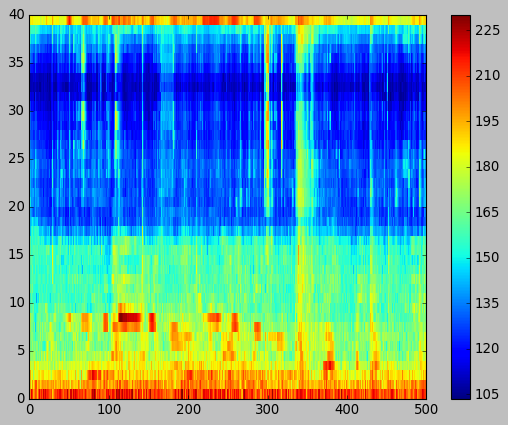

In [73]:
plt.figure(2)
plt.pcolor(filter_banks)
plt.colorbar()
print(filter_banks.shape)

In [ ]:
import sys
sys.path.append('/usr/local/lib/python2.7/dist-packages')
from dnndk import n2cube, dputils
from ctypes import *
import cv2
import numpy as np
import os
import threading
import time
import sys
from matplotlib import pyplot as plt
import matplotlib

In [ ]:
wordlist = ['Indoor', 'Outdoor', 'Transportation']

In [ ]:
KERNEL_CONV = "asc"
KERNEL_CONV_INPUT = "conv2d_1_input"
KERNEL_FC_OUTPUT = "dense_2/Softmax"

In [ ]:
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_CONV)
task = n2cube.dpuCreateTask(kernel, 0)
channel = n2cube.dpuGetOutputTensorChannel(task, KERNEL_FC_OUTPUT)
FCResult = [0 for i in range(channel)]
mean = [104,107,123]

In [ ]:
dputils.dpuSetInputImage(task, KERNEL_CONV_INPUT, img, mean)
n2cube.dpuRunTask(task)
n2cube.dpuGetOutputTensorInHWCFP32(task, KERNEL_FC_OUTPUT, FCResult, channel)
label = FCResult.index(max(FCResult))

In [ ]:
print(label, wordlist[label])

In [ ]:
rtn = n2cube.dpuDestroyKernel(kernel)
n2cube.dpuClose()